## 내가 원하는 숫자 이미지 만들기
### (1) Generator 구성하기

#### 데이터 준비하기

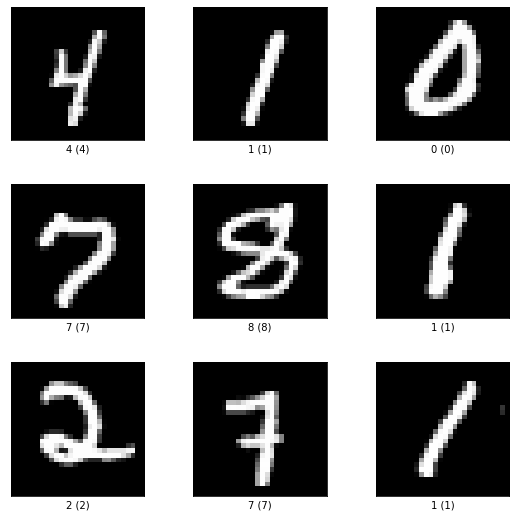

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

* 아래 코드를 실행해 학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의.
* 이미지 픽셀 값을 -1~1 사이의 범위로 변경했고, 레이블 정보를 원-핫 인코딩(one-hot encoding).
* GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 gan_preprocessing()과 cgan_preprocessing() 두 가지 함수를 구성.

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


* 원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인.
* 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 함.

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


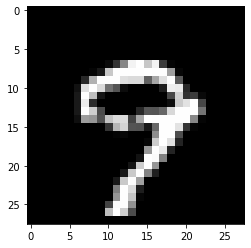

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

원-핫 인코딩으로 표현된 Label과 출력된 이미지가 일치하는지 확인하고 싶지만, 보는 법을 모르시겠다구요?

* 0과 1로 이루어진 원-핫 벡터에는 각자 고유의 인덱스가 있음.
* MNIST의 경우, 숫자 0은 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 숫자 6은 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]의 값을 가집니다.

이제 위 코드의 output을 확인해 이미지 i와 라벨 j가 일치하는지 확인

#### GAN Generator 구성하기
* 이번 구현은 Tensorflow2의 Subclassing 방법을 이용.
* Subclassing 방법은 tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행.
* 이러한 Subclassing 방법은 Pytorch의 모델 구성 방법과도 매우 유사하므로 이에 익숙해진다면 Pytorch의 모델 구성 방법도 빠르게 습득할 수 있음.
* 먼저 GAN의 Generator를 아래와 같이 구현.

In [4]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


* __init__() 메서드 안에서 사용할 모든 레이어를 정의.
* 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용하는 것으로 확인.
* call() 메서드에서는 노이즈를 입력받아 __init__()에서 정의된 레이어들을 순서대로 통과.
* Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환.

#### cGAN Generator 구성하기

In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


* GAN의 Generator보다 구현이 복잡한듯하지만, 이전에 cGAN을 이해한 대로 두 구조의 차이점은 레이블 정보가 추가된다는 것뿐.
* 이번에는 여러분이 위 코드를 자세히 보고, 어떠한 연산이 이루어지는지 생각해 봅시다.
* cGAN의 입력은 2개(노이즈 및 레이블 정보)라는 점을 기억해 주세요. (이전 GAN 코드와 비교하여 잘 생각해 봅시다)

#### 위 코드로 생성한 모델에 대해 입력부터 출력까지 어떤 연산이 이루어지는지 설명해주세요.(init() 메서드에서는 노이즈 및 레이블 입력 각각에 적용할 레이어를 생성했습니다)
1. 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다. (dense_z, dense_y)
2. 1번 문항의 각 결과가 서로 연결되어 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다 (tf.concat, conbined_dense)
3. 2번 문항의 결과가 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성되고 (28,28,1) 크기의 이미지 형태로 변환되어 출력됩니다 (final_dense, reshape)

### (2) Discriminator 구성하기
#### GAN Discriminator 구성하기
* 이전에 임의 노이즈 및 레이블 정보로부터 숫자 이미지를 생성하는 Generator를 구현.
* 이번에는 실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해 보겠음.

* 먼저 GAN의 Discriminator를 아래와 같이 구현.

In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


* 여기에서는 __init__()에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓아놓았음.
* 이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리.
* Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이며, 이를 fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용.
* 이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과.
* 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력.

#### cGAN Discriminator 구성하기
* 다음으로 구현할 cGAN의 Discriminator는 Maxout이라는 특별한 레이어가 사용.
* Maxout은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 함.
* 이렇게 fully-connected 레이어를 2개만 사용한다면 다차원 공간에서 2개의 면이 교차된 모양의 activation function처럼 작동. (다차원 공간은 시각화 하기가 어려움)
* 사용하는 fully-connected 레이어 갯수가 늘어난다면 점점 곡선 형태인 activation function이 될 수 있음. 차원을 늘리면 다차원 공간에 곡면을 나타낼 수 있겠음. (시각화 하기는 어려움.)


* Maxout을 구성.
* tensorflow.keras.layers.Layer 를 상속받아 레이어를 정의다.
* 이전에 모델을 정의한 것과 비슷하게 __init__(), call() 메서드를 구성.

In [7]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅")

✅


* Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개만큼 만들고 그중 최댓값을 출력.
* 예를 들어, 사용할 Maxout 레이어가 units=100, pieces=10으로 설정된다면 입력으로부터 100차원의 representation을 10개 만들고, 10개 중에서 최댓값을 가져와 최종 1개의 100차원 representation이 출력. (위 예시에서는 각각의 wx+b가 모두 100차원)


* 위에서 정의한 Maxout 레이어를 3번만 사용하면 아래와 같이 쉽게 cGAN의 Discriminator를 구성.

In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


* GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용.
* 그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한 번씩 통과한 후 서로 결합되어 Maxout 레이어를 한 번 더 통과.
* 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력.

#### 만약 위와 같은 cGAN의 Disciminator에 (28,28,1) 크기 이미지 및 (10,) 크기 레이블이 입력될 때, 연산의 순서

1. 이미지가 Maxout 레이어를 통과
2. 레이블이 Maxout 레이어를 통과
3. 1)과 2)결과로 나온 representation을 결합(concate) 후 Maxout 레이어를 통과

#### 위 3개 과정의 각 결과 차원 수 : 240, 50, 240

### (3) 학습 및 테스트하기
이전에 정의한 Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해 봅시다.
우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의합니다.
진짜 및 가짜를 구별하기 위해 Binary Cross Entropy를 사용하고, Adam optimizer를 이용해 학습하겠습니다.

In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


#### GAN으로 MNIST 학습하기
* 이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용.
* 여기서는 입력으로 사용되는 노이즈를 100차원으로 설정했으며, 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 아래와 같이 작성.

In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


* 위 함수를 이용해 우선 10 epoch만큼 학습을 진행해 보겠습니다.
* 100번의 반복마다 각 손실(loss)을 출력.

In [11]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.123561382293701, D:0.14443044364452362
[1/10 EPOCHS, 200 ITER] G:2.358126163482666, D:0.14124628901481628
[1/10 EPOCHS, 300 ITER] G:2.8050968647003174, D:0.13854211568832397
[1/10 EPOCHS, 400 ITER] G:3.5054354667663574, D:0.08951108157634735
[2/10 EPOCHS, 100 ITER] G:3.9252777099609375, D:0.11480150371789932
[2/10 EPOCHS, 200 ITER] G:3.697345733642578, D:0.07101365178823471
[2/10 EPOCHS, 300 ITER] G:3.796468496322632, D:0.2054084688425064
[2/10 EPOCHS, 400 ITER] G:2.795112133026123, D:0.11747030168771744
[3/10 EPOCHS, 100 ITER] G:3.2545032501220703, D:0.25526532530784607
[3/10 EPOCHS, 200 ITER] G:3.095583915710449, D:0.1778688281774521
[3/10 EPOCHS, 300 ITER] G:4.1363677978515625, D:0.037358708679676056
[3/10 EPOCHS, 400 ITER] G:5.343088150024414, D:0.07200594991445541
[4/10 EPOCHS, 100 ITER] G:3.1865503787994385, D:0.13521525263786316
[4/10 EPOCHS, 200 ITER] G:4.596335411071777, D:0.22595448791980743
[4/10 EPOCHS, 300 ITER] G:2.5699543952941895, D:0.2205975

* 짧은 시간 학습된 모델을 테스트.
* 100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화.
* 경고 메시지가 출력된다면 그냥 무시.

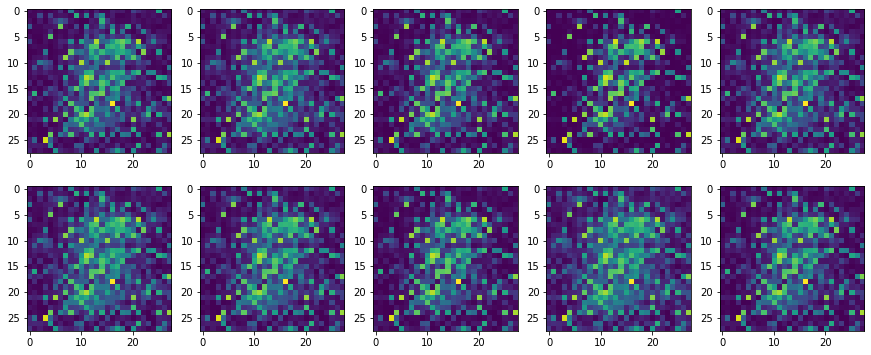

In [12]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

* 결과를 보니 아마도 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없나 봅니다.
* 위 구현을 그대로 500 epoch 학습한 가중치를 준비해 두었으니 한번 사용해 봅시다.

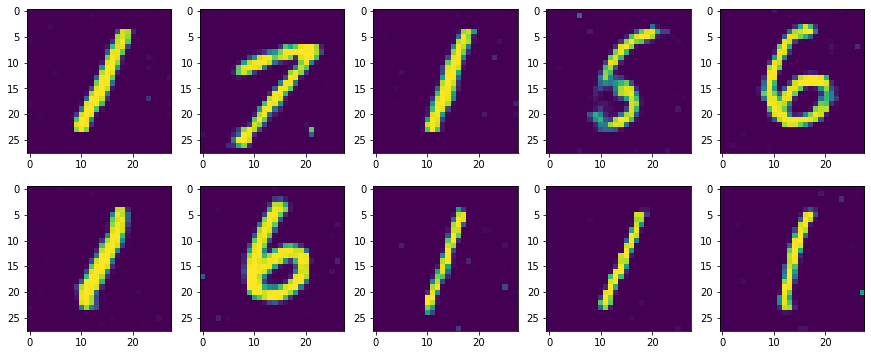

In [13]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

* 위에 보이는 10개의 결과 이미지는 서로 다른 숫자들이 시각화되었을 것입니다 (아닐 수도 있습니다).
* 이러한 방법으로는 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 할 수 있습니다. 내가 원하는 숫자를 바로 얻어내기 위해 아래에서 cGAN을 학습 시켜 봅시다.

#### cGAN으로 MNIST 학습하기
* 이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용합니다.
* 위에서 실행했던 GAN 학습처럼 약간의 학습으로는 제대로 된 생성 결과를 얻을 수 없을 테니 이번에는 연습 삼아 1 epoch만 학습 시켜 보겠습니다.

In [14]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.428593635559082, D:0.005874300841242075
[1/1 EPOCHS, 199 ITER] G:4.974173545837402, D:0.011053787544369698
[1/1 EPOCHS, 299 ITER] G:4.885127067565918, D:0.015032434836030006
[1/1 EPOCHS, 399 ITER] G:5.9606475830078125, D:0.009485623799264431


* 학습 과정에서 Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없습니다.
* 위 코드로 짧게나마 학습시켜봤는데, 충분한 학습이 되기엔 더 많은 시간을 투자해야 합니다.
* 뒤에서 학습해야 할 것들이 많이 남아있으니, 시간을 아끼기 위해 위 코드로 500 epoch 학습한 가중치를 준비해 두었습니다.


* 아래 코드의 가장 윗줄에 있는 number라는 변수에 숫자를 할당하지 않았습니다.
* number에 0~9 사이의 숫자 중 생성하길 원하는 숫자를 입력해 주시고 아래 코드를 실행시켜봅시다.
* 경고 메시지가 출력된다면 그냥 무시하셔도 됩니다.

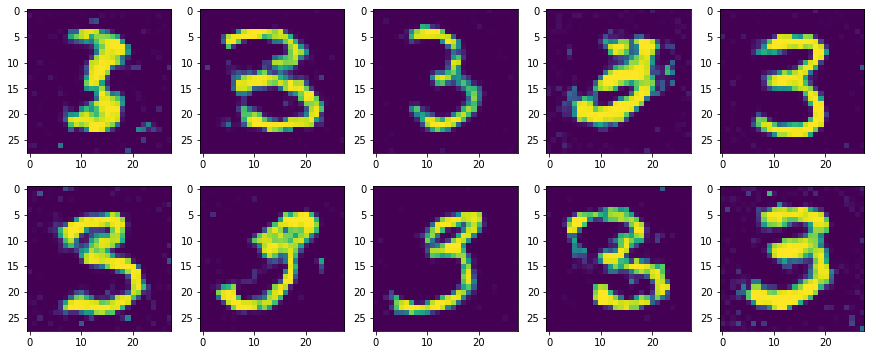

In [15]:
number = 3 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

* 출력된 10개 시각화 결과는 어떤가요? 아마도 number에 입력한 숫자에 해당하는 손글씨가 시각화되었을 것입니다.
* cGAN을 사용해 조건을 주고 학습하면 이렇게 특정한 숫자를 만들어내기가 훨씬 쉬워졌습니다.

-----

## 난 스케치를 할 테니 너는 채색을 하거라
### (1) 데이터 준비하기
* 이번에는 앞서 알아본 pix2pix 모델에 대해서 직접 구현하고 실험해 봅시다.
* 사용해 볼 데이터셋은 Sketch2Pokemon이라는 데이터셋입니다.

* 학습용 데이터 셋에 830개의 이미지가 있으며, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성

In [16]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


* 출처의 내용과 같이 830개 이미지가 있음을 확인.

* 이번에는 아래 코드를 이용해 각각의 이미지들이 어떻게 생겼는지 확인해 봅시다.
* 학습용 데이터셋에서 임의로 6장을 선택하여 시각화합니다.

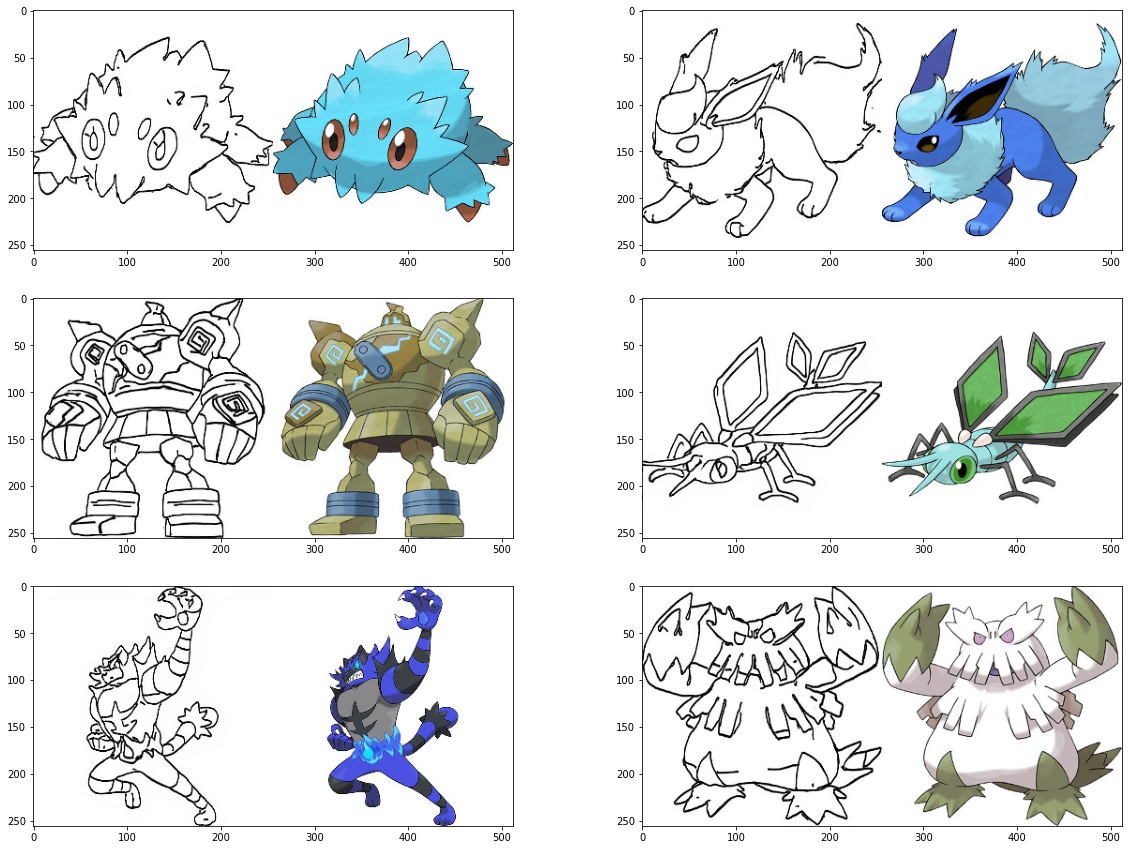

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

* 하나의 이미지에 포켓몬 스케치와 실제 포켓몬 이미지가 함께 포함되어 있음을 확인할 수 있습니다.
* 위 코드를 여러 번 반복 실행해 보면 일부는 제대로 스케치 되지 않은 이미지도 확인할 수 있습니다.
* 출처를 확인해 보니 직접 그려서 만든 데이터셋이 아닌 스케치 생성 모델을 이용해서 만들었다고 함.

In [18]:
# 이미지를 하나 열어 아래와 같이 크기를 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* (256, 512, 3)으로 확인.
* 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용.

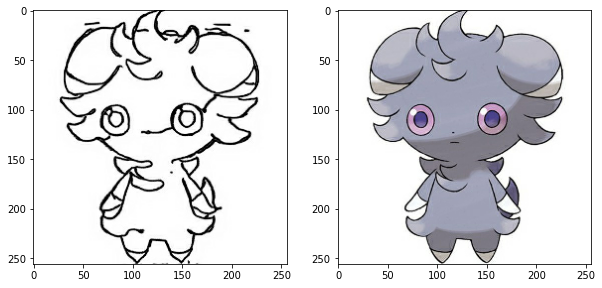

In [19]:
#  이미지를 나누기
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

* 위와 같이 두 개 이미지로 나누었습니다.
* 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여
* 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표.


* 앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 약 800개뿐.
* 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용.

In [20]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


* apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용.

#### apply_augmentation 함수에 두 이미지가 입력되면 어떠한 과정
1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
4. 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
5. 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
6. 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

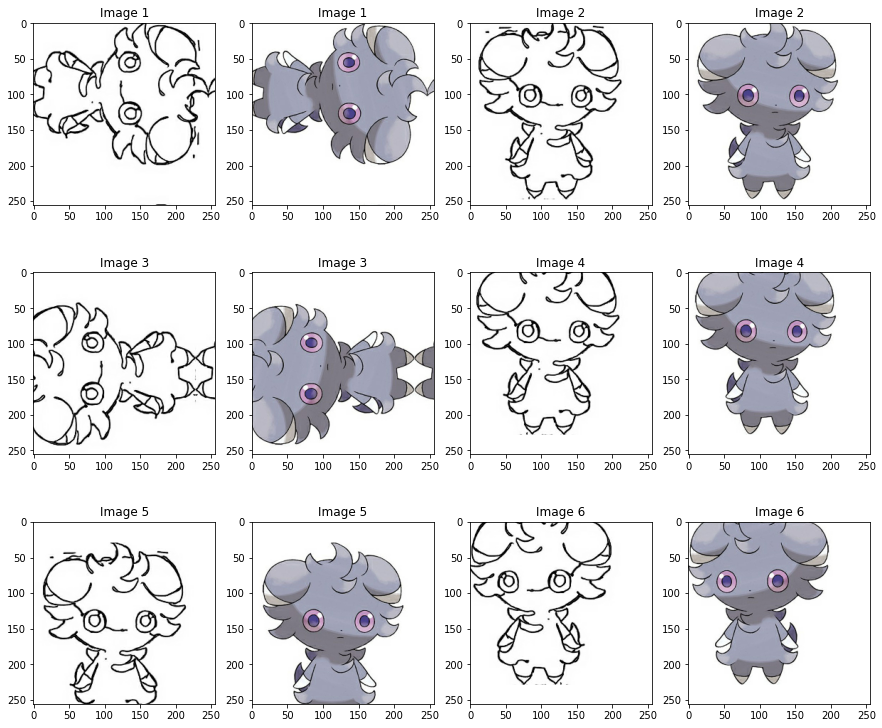

In [21]:
# 위와 같이 구성한 함수를 데이터에 적용해 시각화
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

* 매우 다양한 이미지가 생성.
* 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대.

* 마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인.

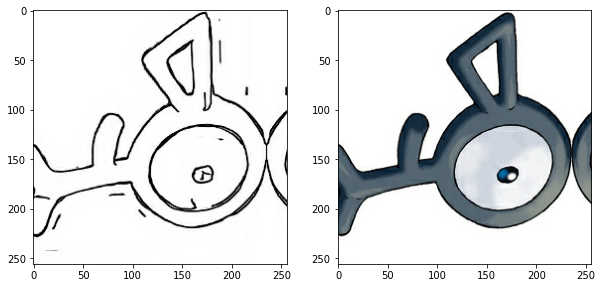

In [22]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### (2) Generator 구성하기
이제부터 본격적으로 Pix2Pix 구조를 구현합니다. 앞서 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들겠습니다.


#### Generator의 구성요소 알아보기
먼저, pix2pix 논문에서 Generator를 구성하는데 필요한 정보를 아래에 가져왔습니다. 한번 읽어보시고 아래 질문에 답해봅시다.

#### 논문에서 표기한 encoder의 "C64"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합을 나타내나요?
* 64개의 4x4 필터에 stride 2를 적용한 Convolution → 0.2 slope의 LeakyReLU (위 논문의 아래 단락에 BatchNorm을 사용하지 않는다고 쓰여 있습니다)

#### 논문에서 표기한 decoder의 "CD512"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합을 나타내나요?
* 512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution → BatchNorm → 50% Dropout → ReLU

위 두 개의 질문 : Generator를 구성하는데 필요한 레이어들은 대략적으로 숙지.

#### Generator 구현하기
위 정보들을 토대로 여러분의 머릿속에 희미하게 그려진 Generator의 Encoder 부분을 구현.
먼저 위 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었습니다.

In [23]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


* __init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정.
* 이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정.
* Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성

In [24]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


* 각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정해 두었으며, blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과합니다.
* 앞서 퀴즈로 알아본 것처럼 Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않습니다.
* get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았습니다.
* 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴봅시다. 만들어 놓은 get_summary 메서드를 바로 불러오시면 됩니다.

In [25]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

* 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인.

* 이번엔 Decoder를 구현.
* Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러 번 반복하여 아래와 같이 Decoder를 만들겠습니다.

In [26]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


* 처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인.
* 마찬가지로 (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해 봅시다.

In [27]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

* (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력.

* 위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있겠군요. 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있습니다.
* 아래 코드와 같이 tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성.

In [28]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


* Generator를 잘 작동시키기 위해서는 약 4000만 개의 파라미터를 잘 학습시켜야 함.

### (3) Generator 재구성하기
* 지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 봤습니다.
* 하지만 앞서 설명드린 것처럼 Pix2Pix의 Generator 구조는 아래 그림처럼 두 가지를 제안.


* 단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보임.

* Encoder에서 출력된 결과를 Decoder의 입력으로 연결했고, 이 외에 추가적으로 Encoder와 Decoder를 연결시키는 부분은 없었습니다. 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 위 그림의 U-Net 구조를 만들고 실험해 봅시다. (아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용하겠습니다)

* 먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현.

In [29]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


* 여기서 특별히 수정해야 할 부분은 없습니다. 그대로 가져다가 사용.

* 정의된 블록들을 이용해 한 번에 U-Net Generator를 정의.
* 아래 모델의 __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 forward propagation 하도록 합니다.
* 이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인.

In [30]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


* 먼저, __init__() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행.
* 이때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았습니다.
* 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
* features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용.

* 아래 질문에 답하면서 조금 더 자세히 이해해 봅시다.


#### 위 코드의 call() 내에서 features = features[:-1] 는 왜 필요할까요?
* Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아닙니다.

#### 위 코드의 call() 내의 Decoder 연산 부분에서 features[::-1] 는 왜 필요할까요?
* Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룹니다(맨 위 U-Net 구조 사진 참고). features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다.

#### 아래와 같은 데이터 A, B가 있을 때,
#### 데이터 A 크기 : (32,128,128,200) #(batch, width, height, channel)
#### 데이터 B 크기 : (32,128,128,400) #(batch, width, height, channel)
#### 여기서 사용되는 skip connection은 layers.Concatenate() 결과의 크기는 무엇일까요?
* (128,128,600) layers.Concatenate() 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결됩니다.

마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인

In [31]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

* 이전 Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만 개였는데, Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개로 꽤나 많이 늘어났습니다.

#### U-Net Generator의 파라미터가 늘어난 곳은 Encoder와 Decoder 중 어디일까요? 또한, 두 종류의 Generator 구조에서 동일한 수의 convolution 레이어를 사용했는데, 구체적으로 어느 부분에서 파라미터가 늘어났을까요?
* U-Net Generator의 Decoder 구조 내 파라미터가 많아졌습니다. 이 부분의 각 convolution 레이어에서 사용된 필터의 수는 두 종류의 Decoder에서 동일하지만, 그 크기가 다릅니다.
* 예를 들어, 이전 Decoder 블록의 출력의 크기가 (16,16,512)라면, Encoder-decoder Generator의 경우, Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x512 입니다.
* U-Net Generator의 경우, Encoder 내 블록 출력이 함께 연결되어 Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x(512+512) 입니다.

* 정리하면, U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어났습니다.

### (4) Discriminator 구성하기
* Generator만으로 좋은 결과를 도출하기에는 부족.
* 조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요.
* 이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜 봅시다.

#### Discriminator의 구성요소 알아보기
* Generator를 만들기 전에 봤듯이 먼저 Pix2Pix 논문에서 Discriminator를 구성하는데 필요한 정보를 아래에 가져왔습니다.

* Generator의 구성 요소와 똑같이 "C64" 등으로 표기되어 있습니다.
* 진짜 및 가짜 이미지를 판별하기 위해 최종 출력에 sigmoid를 사용하는 것을 제외하면 특별한 변경 사항은 없는 것 같습니다.

#### Discriminator 구현하기
마찬가지로 Discriminator에 사용할 기본적인 블록부터 만들겠습니다.

In [32]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


* __init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했습니다.
* 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능.

* 아래 질문에 답하면서 위 코드가 어떻게 동작하는지 생각해 봅시다.

#### 위에서 만든 DiscBlock의 설정을 다음과 같이 하여 DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True) 으로 생성된 블록에 (width, height, channel) = (128, 128, 32) 크기가 입력된다면, 블록 내부에서 순서대로 어떠한 레이어를 통과하는지, 그리고 각 레이어를 통과했을 때 출력 크기는 어떻게 되는지 적어주세요.

1. 패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32)
2. Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64)
3. BatchNormalization 레이어 통과 layers.BatchNormalization() → (127,127,64)
4. LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)

* 이전 Discriminator를 표현한 그림에서 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소한다는 것을 언급했었습니다.
* 1씩 감소시키기 위한 방법이 위 질문의 답이며, 이에 대해 자세히 설명.

1. (128,128,32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어납니다. 출력 : (130,130,32)
2. 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듭니다. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있습니다. 채널 수는 사용한 필터 개수와 같습니다. 출력 : (127,127,64)
3. 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않습니다.


* 간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해 봅시다.

In [33]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


* 이러한 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있습니다.
* 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 되겠습니다.

* Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했습니다.
* 사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어봅시다.

In [34]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


* __init__() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었습니다.
* 첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용.

* 각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인.

In [35]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

* 두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치.
* 시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화.

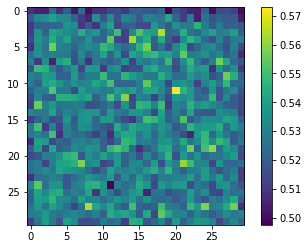

In [36]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

* 이전 PatchGAN에 대해 설명했던 것처럼, 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀 값은 원래 입력의 (70,70) 패치에 대한 분류 결과.
* 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있겠죠.
* 각각의 픽셀 값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는 데 사용.

* 드디어 Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝.
* 다음 단계에서 본격적인 모델 학습을 진행!

### (5) 학습 및 테스트하기
* 이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해 봅시다.
* 먼저 학습에 필요한 손실 함수부터 정의.


* 레이블 정보만 있는 입력에 대해 여러 손실 함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실 함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 냈습니다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해 봅시다.

In [37]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


Generator 및 Discriminator의 손실 계산을 각각 정의.

#### Generator의 손실 함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있습니다.
* 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며,
* 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다.
* 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.

#### Discriminator의 손실 함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며,
* 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다.
* Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.

* 사용할 optimizer는 논문과 동일하게 아래와 같이 설정.

In [38]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


* 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현

In [39]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


* 전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않습니다.
* 다만 위 코드의 gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인하셨나요? (## 이 표시가 있는 부분을 확인해 주세요.)

* λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ=100을 사용했습니다.

* 앞서 정의한 함수를 이용해서 학습을 진행합니다. 우선 10 epoch 학습해 봅시다.

In [40]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9192                     
L1_loss:0.4828                     
Discriminator_loss:1.0753

EPOCH[1] - STEP[20]                     
Generator_loss:1.6247                     
L1_loss:0.3259                     
Discriminator_loss:2.0108

EPOCH[1] - STEP[30]                     
Generator_loss:0.8776                     
L1_loss:0.3167                     
Discriminator_loss:1.2136

EPOCH[1] - STEP[40]                     
Generator_loss:1.0993                     
L1_loss:0.2620                     
Discriminator_loss:0.9358

EPOCH[1] - STEP[50]                     
Generator_loss:1.4475                     
L1_loss:0.2426                     
Discriminator_loss:0.6573

EPOCH[1] - STEP[60]                     
Generator_loss:1.5321                     
L1_loss:0.2831                     
Discriminator_loss:0.6320

EPOCH[1] - STEP[70]                     
Generator_loss:1.5782                     
L1_loss:0.2543                    

* 아래 코드로 짧게나마 학습해 본 모델에 채색을 시켜봅시다. 

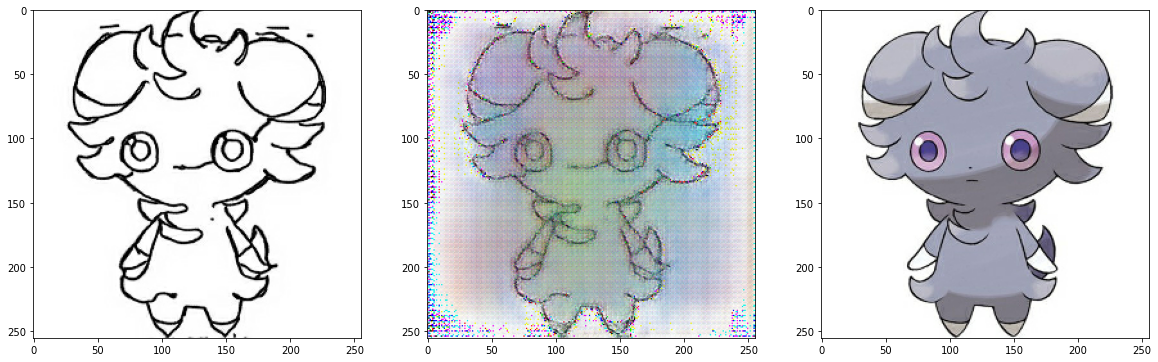

In [41]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

* 데이터셋을 제공한 출처를 보면, Pix2Pix로 128 epoch 학습 후 테스트 결과가 아래와 같다고 합니다.
* 이전 10 epoch 학습의 결과보다는 훨씬 낫지만, 조금 오래 학습했어도 채색해야 할 전체적인 색감 정도만 학습되며 아직까지 세부적으로는 제대로 채색되지 않다는 것을 확인할 수 있습니다.


* Pix2Pix가 등장한 지 꽤 오랜 시간이 흘렀고 그동안 많은 발전이 있었습니다. Pix2Pix의 출력 결과가 만족스럽지 않더라도 기술적으로는 의미가 매우 큽니다. 네이버 AI Painter와 같은 서비스도 Pix2Pix와 같은 시도들이 없었다면 등장할 수 없었을 거예요.

* 지금까지 꽤 많은 시간을 투자해서 Encoder-Decoder Generator, U-Net Generator, Discriminator의 구현까지 이해하느라 고생하셨습니다. 앞서 다뤘던 코드의 이해에 큰 어려움이 없었다면, 연습을 통해 이와 비슷한 구조의 모델들 또한 쉽게 구현할 수 있을 것입니다. (U-Net Generator를 구현했으니 원래 segmentation에 사용되었던 U-Net도 쉽게 구현할 수 있습니다!).

* 이번 학습을 통해서 여러분이 Pix2Pix 구조뿐만 아니라 CNN 기반의 어떠한 구조라도 자신을 갖고 구현을 시작할 수 있길 바랍니다.
* 마지막으로 다음 단계로 넘어가서 Pix2Pix를 이용한 프로젝트를 수행해 봅시다.